In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import warnings

warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
def summary_data(dfs=None, labels=None, benchmark=None):
    summary_data = []
    for df, label in zip(dfs, labels):
        # For verified count and average time, consider only the specified statuses.
        valid_status = ['safe-incomplete', 'safe']

        df_verified = df[df['Status'].isin(valid_status)]
        verified_count = len(df_verified)
        avg_time = df_verified['Time'].sum() / verified_count if verified_count > 0 else 0

        # Compute the upper bound for this method.
        total_instances = len(df)
        unsafe_pgd_count = len(df[df['Status'] == 'unsafe-pgd'])
        upper_bound = total_instances - unsafe_pgd_count

        summary_data.append({
            'Method': label,
            'Verified': verified_count,
            'AvgTime': avg_time,
            'UpperBound': upper_bound
        })
        summary_df = pd.DataFrame(summary_data)
        summary_df.to_csv(f'/data/{benchmark}_summary.csv', index=False)
    return summary_df

In [3]:
def plot_verified_and_time(dfs=None, labels=None, benchmark=None):
    # If the dataframes are not provided, read the summary data from the CSV file.
    # Otherwise, compute the summary data from the list of dataframes.
    if dfs is not None:
        summary_df = summary_data(dfs, labels, benchmark)
    else:
        summary_df = pd.read_csv(f'data/{benchmark}_summary.csv')

    unified_UB = summary_df['UpperBound'].max() if not summary_df.empty else 0

    # Set seaborn aesthetics.
    sns.set_style('whitegrid')
    sns.set_context('talk', font_scale=0.9)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Define dark color endpoints for the gradient.
    dark_blue = np.array([0.0, 0.0, 0.5])  # Lower value: dark blue
    dark_red  = np.array([0.5, 0.0, 0.0])  # Higher value: dark red

    # ---------------------------
    # Left subplot: Verified Instances
    # ---------------------------
    sns.barplot(data=summary_df, x='Method', y='Verified', ax=ax1)
    ax1.set_title('Verified Instances by Method')
    ax1.set_xlabel(f'{benchmark}')
    ax1.set_ylabel('Number of Verified Instances')
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

    # Determine the range for Verified values.
    verified_values = summary_df['Verified']
    min_verified = verified_values.min()
    max_verified = verified_values.max()

    # Iterate over each bar and set its color based on the normalized Verified value.
    for p in ax1.patches:
        height = p.get_height()
        # Normalize value (avoid division by zero)
        norm = (height - min_verified) / (max_verified - min_verified) if max_verified != min_verified else 0.5
        # Interpolate between dark blue and dark red.
        color = (1 - norm) * dark_blue + norm * dark_red
        p.set_facecolor(color)
        # Annotate each bar.
        ax1.annotate(f'{int(height)}',
                     (p.get_x() + p.get_width() / 2, height),
                     ha='center', va='bottom', fontsize=12, color='black')

    # Draw a unified dotted red line for the upper bound across the entire plot.
    ax1.axhline(y=unified_UB, color='red', linestyle=':', linewidth=2,
                label=f'Upper Bound: {unified_UB}')
    ax1.legend(fontsize=12)

    # ---------------------------
    # Right subplot: Verified Average Time
    # ---------------------------
    sns.barplot(data=summary_df, x='Method', y='AvgTime', ax=ax2)
    ax2.set_title('Verified Average Time by Method')
    ax2.set_xlabel(f'{benchmark}')
    ax2.set_ylabel('Average Time')
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')

    # Determine the range for AvgTime values.
    time_values = summary_df['AvgTime']
    min_time = time_values.min()
    max_time = time_values.max()

    # Iterate over each bar and set its color based on the normalized AvgTime value.
    for p in ax2.patches:
        height = p.get_height()
        norm = (height - min_time) / (max_time - min_time) if max_time != min_time else 0.5
        color = (1 - norm) * dark_blue + norm * dark_red
        p.set_facecolor(color)
        # Annotate each bar with the average time formatted to two decimals.
        ax2.annotate(f'{height:.2f}',
                     (p.get_x() + p.get_width() / 2, height),
                     ha='center', va='bottom', fontsize=12, color='black')

    plt.tight_layout()
    plt.show()


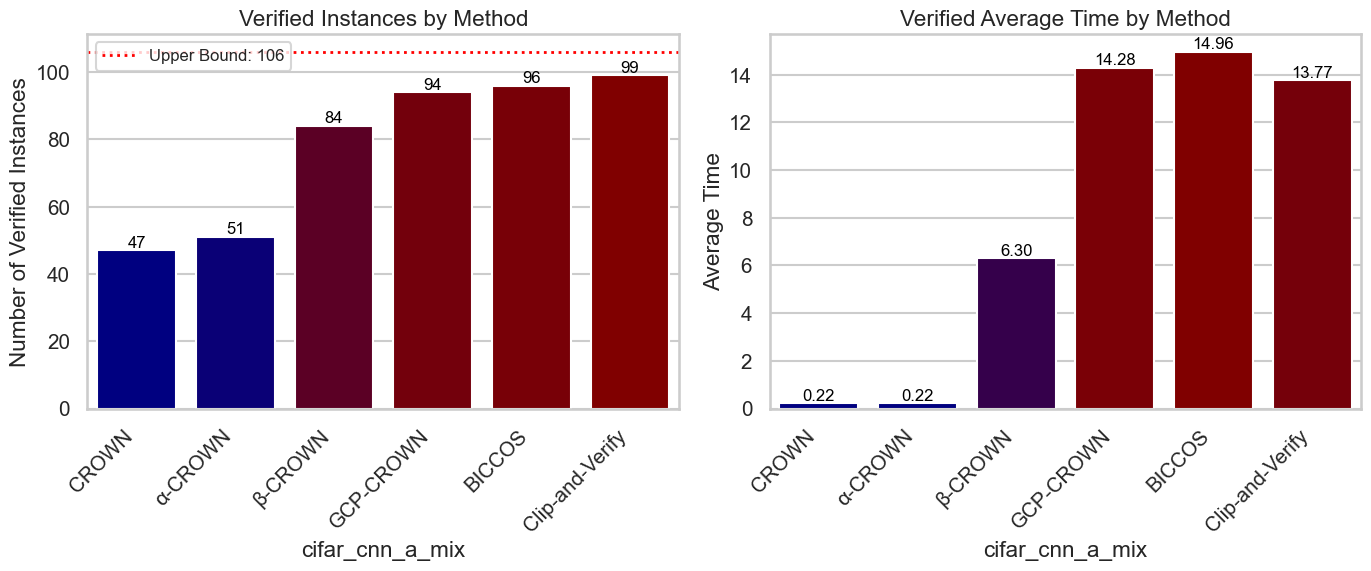

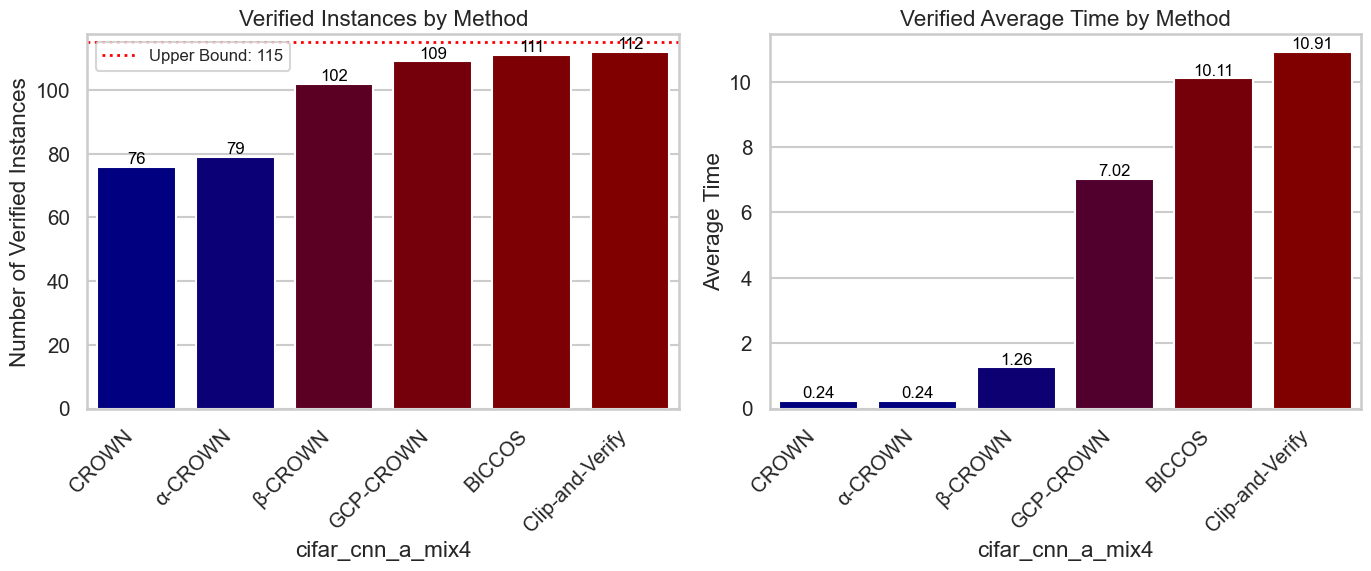

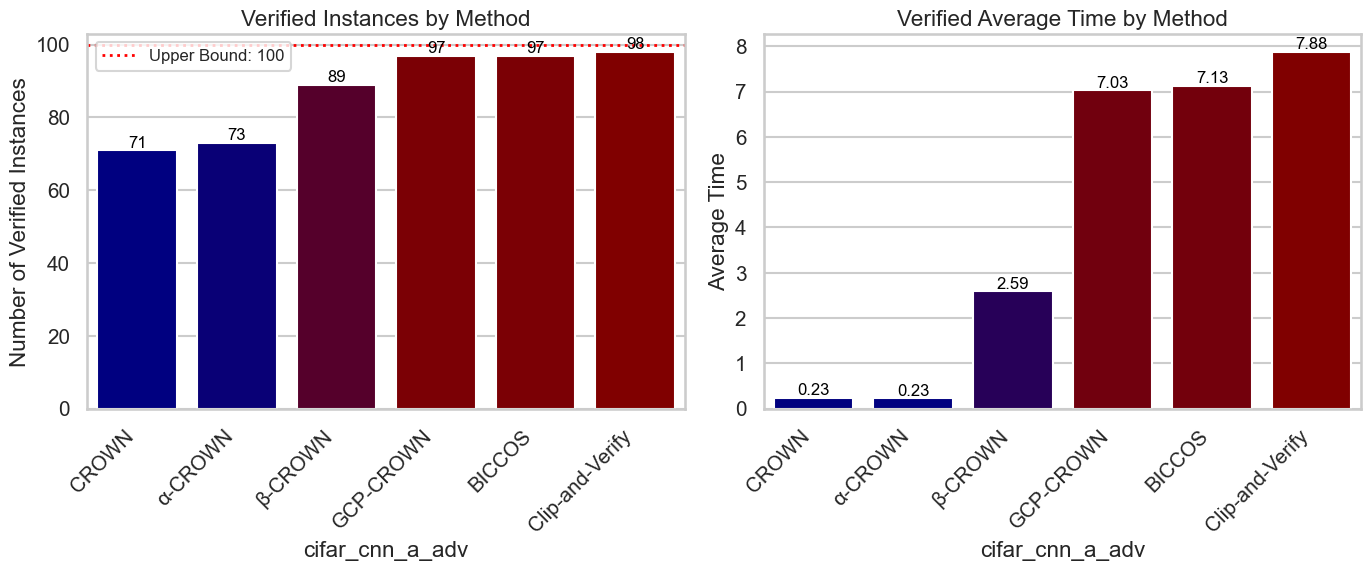

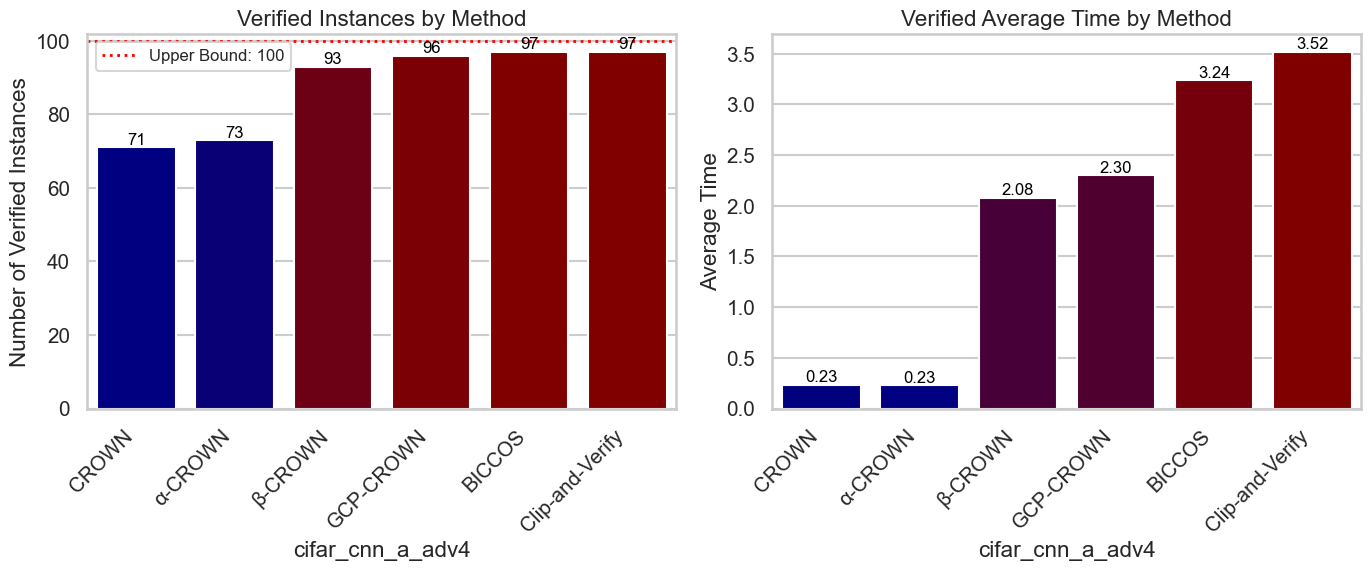

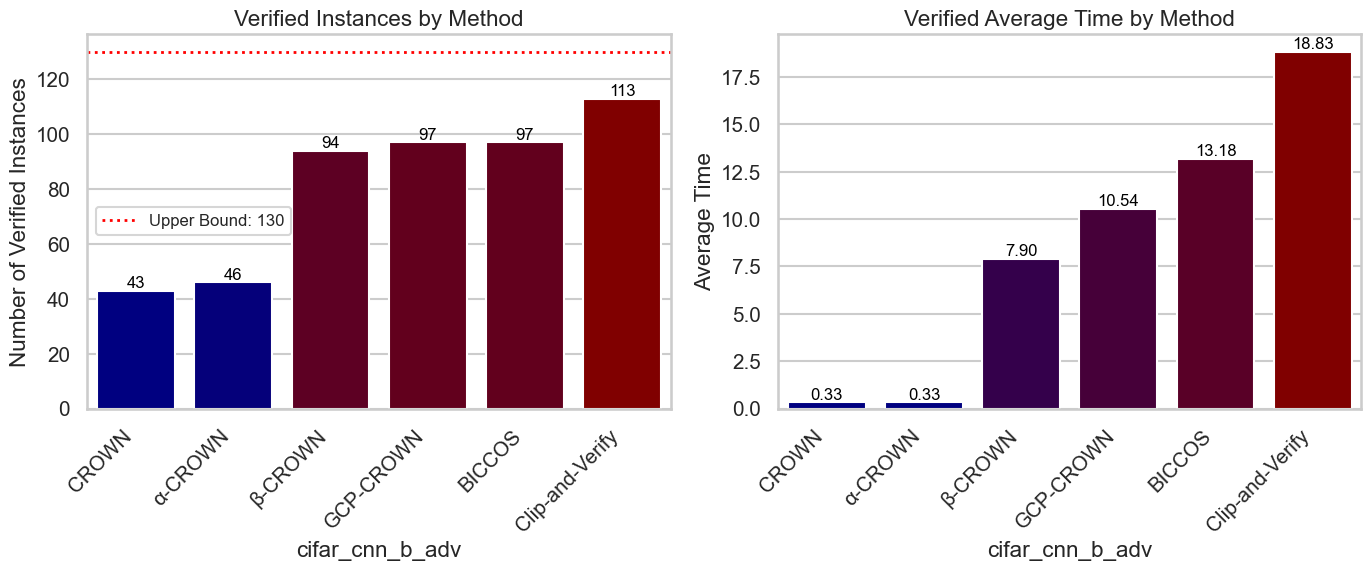

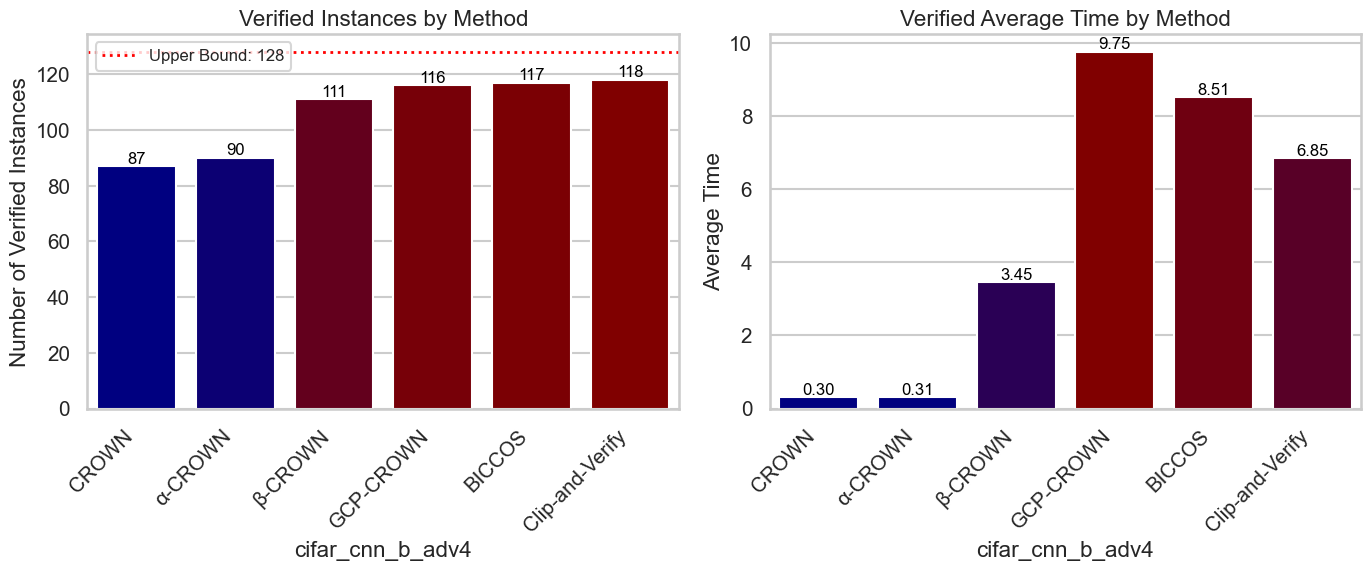

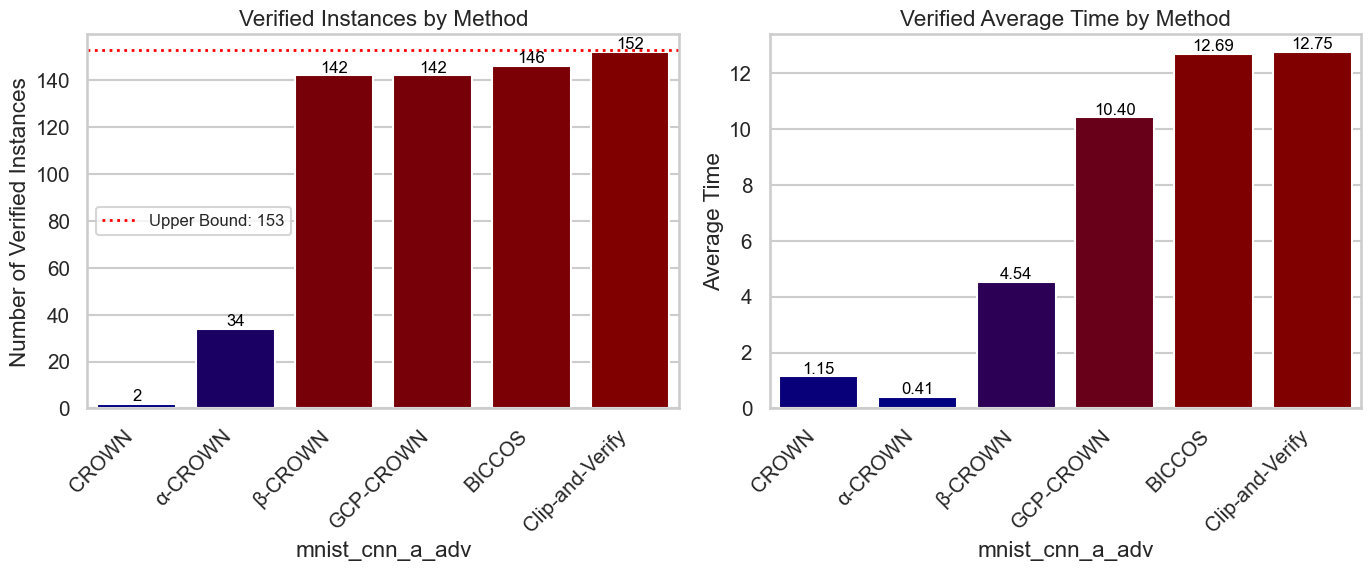

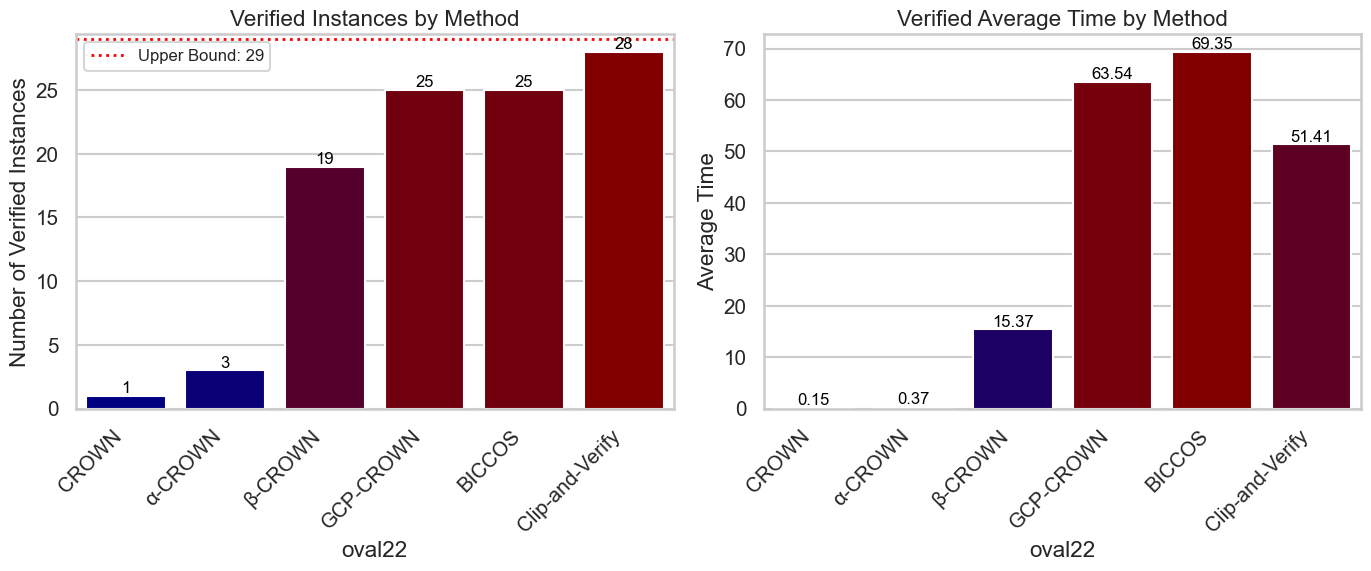

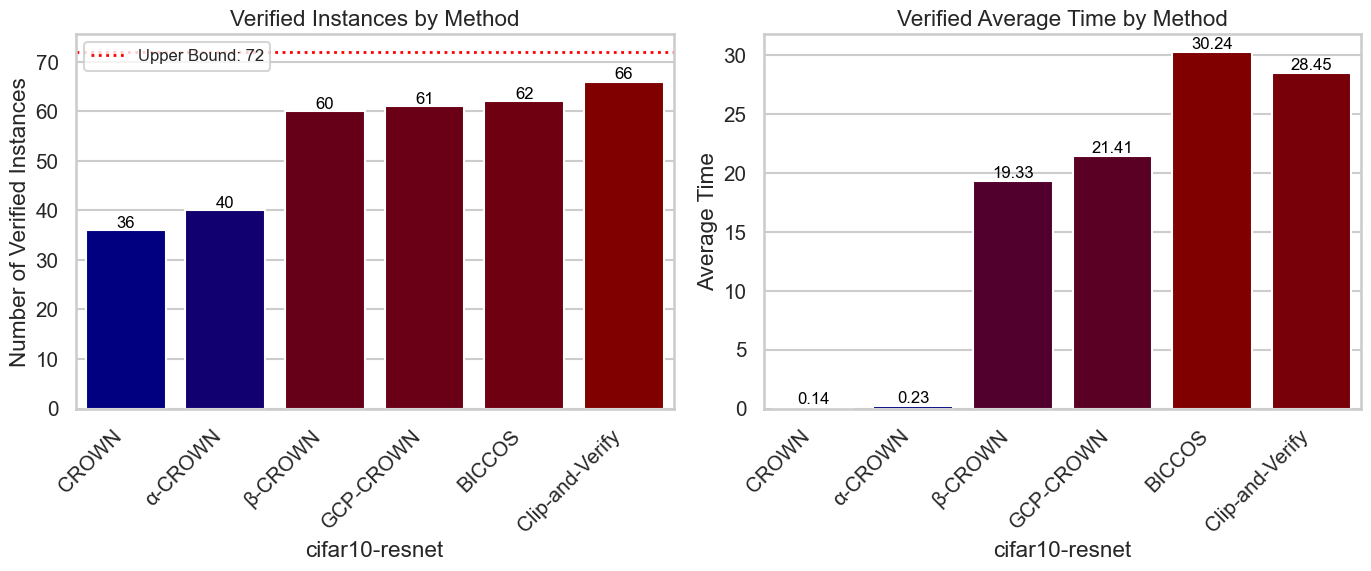

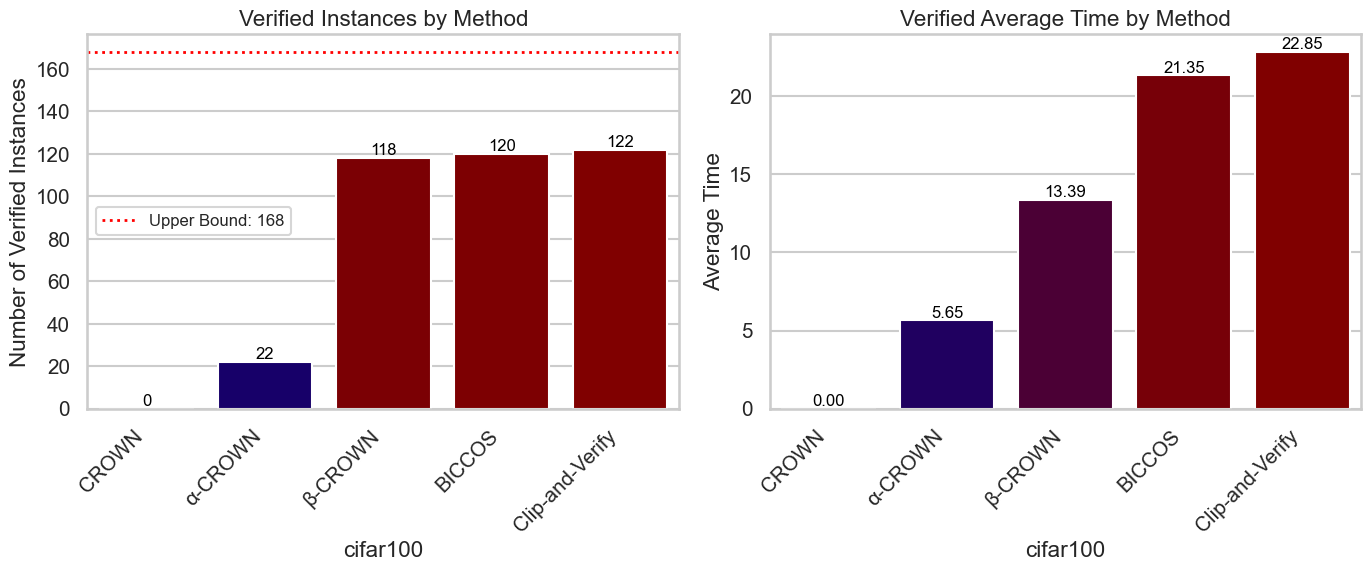

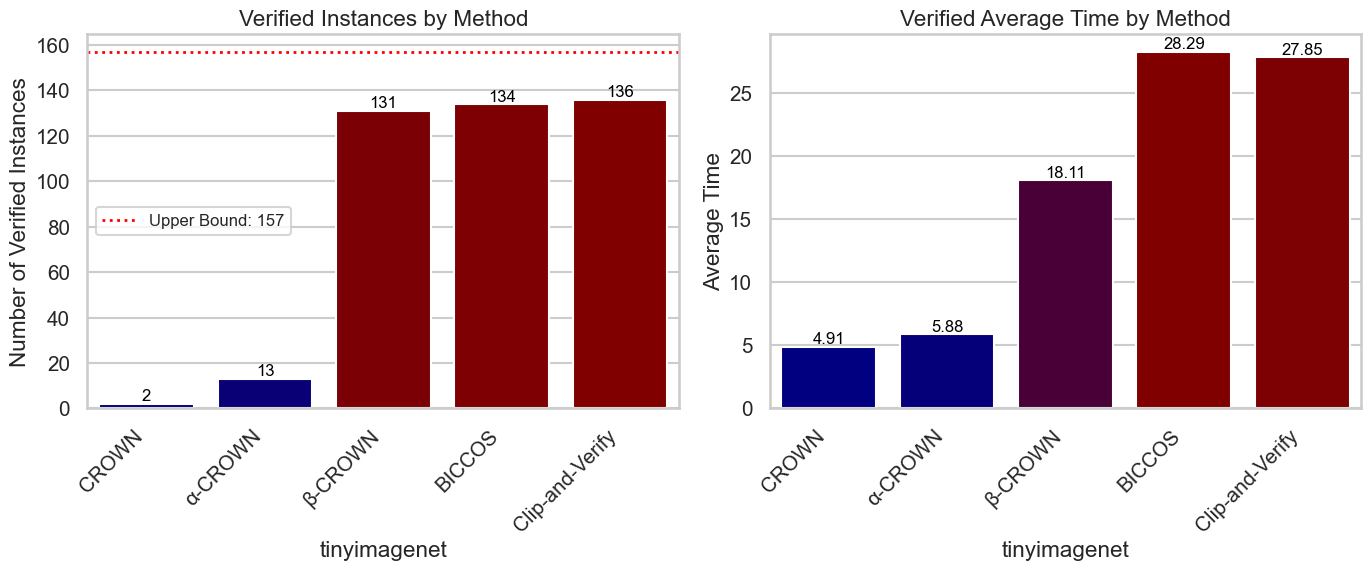

In [4]:
benchmarks = [
    'cifar_cnn_a_mix',
    'cifar_cnn_a_mix4',
    'cifar_cnn_a_adv',
    'cifar_cnn_a_adv4',
    'cifar_cnn_b_adv',
    'cifar_cnn_b_adv4',
    'mnist_cnn_a_adv',
    'oval22',
    'cifar10-resnet',
    'cifar100',
    'tinyimagenet'
]

for benchmark in benchmarks:
    plot_verified_and_time(benchmark=benchmark)